<a href="https://colab.research.google.com/github/Klatane/Test/blob/main/Review_Sys.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import string
import re
import nltk
from nltk.corpus import stopwords as StopWords
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, log_loss
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings("ignore")

In [2]:
dat = pd.read_csv('c.csv')
dat

,Reviewer's rate,Reviewer's content,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5
0,5.0,"xây dựng quá công phunhững hoa văn, họa tiết đ...",NaN,NaN,NaN,NaN
1,4.0,Tọa lạc tại thị trấn Cát Thành - Trực Ninh – N...,NaN,NaN,NaN,NaN
2,4.0,We went on Tuesday morning and the doors were ...,NaN,NaN,NaN,NaN
3,5.0,Một trong những nhà thờ công giáo được xây dựn...,NaN,NaN,NaN,NaN
4,5.0,"khuôn viên rộng lớn, thoáng mátnơi đây thật tu...",NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
111170,NaN,NaN,NaN,NaN,NaN,NaN
111171,NaN,NaN,NaN,NaN,NaN,NaN
111172,NaN,NaN,NaN,NaN,NaN,NaN
111173,NaN,NaN,NaN,NaN,NaN,NaN


#Xử lý dữ liệu


In [3]:
data1 = dat.drop(range(999,111175), axis = 0)

In [4]:
data = data1[["Reviewer's rate","Reviewer's content"]]
data

,Reviewer's rate,Reviewer's content
0,5.0,"xây dựng quá công phunhững hoa văn, họa tiết đ..."
1,4.0,Tọa lạc tại thị trấn Cát Thành - Trực Ninh – N...
2,4.0,We went on Tuesday morning and the doors were ...
3,5.0,Một trong những nhà thờ công giáo được xây dựn...
4,5.0,"khuôn viên rộng lớn, thoáng mátnơi đây thật tu..."
...,...,...
994,3.0,"To get the view from the Vietnamese only, whic..."
995,5.0,This is definitely worth a visit and it is wel...
996,5.0,I took a cab and walked through the prison alo...
997,4.0,Very sad place to visit but well worth going t...


In [5]:
data = data.dropna()
data.drop_duplicates(inplace=True)

In [7]:
data["Sentiment"] = data["Reviewer's rate"].replace(to_replace=[1,2,3,4,5], value=["Tiêu cực","Tiêu cực","Tiêu cực","Tốt","Tốt"])

In [8]:
def preprocess_data(text):
    """
    Returns text after removing numbers, punctuations, urls, emojis, html tags and lowercasing all the words in given text.
    """
    text = re.sub(r'[0-9]+', '', str(text))   # removing numbers
    text = re.sub(r'[^\w\s]', '', str(text))   # removing punctuations
    text = " ".join(x.lower() for x in text.split())  # lower casing the text
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  # removing urls
    text = re.sub(r'<.*?>', '', text) # removing html tags
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)
    text = " ".join(x for x in text.split() if x not in StopWords.words('english'))
    return text

In [10]:
# Kiểm tra thông tin sau khi loại bỏ các hàng giá trị rỗng và các hàng trùng lặp
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 999 entries, 0 to 998
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Reviewer's rate     999 non-null    float64
 1   Reviewer's content  999 non-null    object 
 2   Sentiment           999 non-null    object 
dtypes: float64(1), object(2)
memory usage: 31.2+ KB


In [44]:
# Kiểm tra phần trăm hàng cho mỗi xếp hạng
data["Reviewer's rate"].value_counts(normalize = True)

5.0    0.551552
4.0    0.316316
3.0    0.091091
1.0    0.021021
2.0    0.020020
Name: Reviewer's rate, dtype: float64

In [12]:
# Kiểm tra thông tin cho tập dữ liệu sau khi loại bỏ các hàng
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 999 entries, 0 to 998
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Reviewer's rate     999 non-null    float64
 1   Reviewer's content  999 non-null    object 
 2   Sentiment           999 non-null    object 
dtypes: float64(1), object(2)
memory usage: 31.2+ KB


In [13]:
# Tạo cột cho số từ trong bài đánh giá

# Word count
data["Word_count"] = data["Reviewer's content"].apply(lambda x: len(str(x).split()))
data.head()

,Reviewer's rate,Reviewer's content,Sentiment,Word_count
0,5.0,"xây dựng quá công phunhững hoa văn, họa tiết đ...",Tốt,33
1,4.0,Tọa lạc tại thị trấn Cát Thành - Trực Ninh – N...,Tốt,47
2,4.0,We went on Tuesday morning and the doors were ...,Tốt,109
3,5.0,Một trong những nhà thờ công giáo được xây dựn...,Tốt,27
4,5.0,"khuôn viên rộng lớn, thoáng mátnơi đây thật tu...",Tốt,50


In [14]:
# Tạo cột cho số từ duy nhất trong bài đánh giá

# Unique word count
data["Unique_word_count"] = data["Reviewer's content"].apply(lambda x: len(set(str(x).split())))
data.head()

,Reviewer's rate,Reviewer's content,Sentiment,Word_count,Unique_word_count
0,5.0,"xây dựng quá công phunhững hoa văn, họa tiết đ...",Tốt,33,32
1,4.0,Tọa lạc tại thị trấn Cát Thành - Trực Ninh – N...,Tốt,47,42
2,4.0,We went on Tuesday morning and the doors were ...,Tốt,109,87
3,5.0,Một trong những nhà thờ công giáo được xây dựn...,Tốt,27,27
4,5.0,"khuôn viên rộng lớn, thoáng mátnơi đây thật tu...",Tốt,50,47


In [15]:
# Tạo một cột cho độ dài từ trung bình trong một bài đánh giá

# mean word length
data["Mean_word_length"] = data["Reviewer's content"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
data.head()

,Reviewer's rate,Reviewer's content,Sentiment,Word_count,Unique_word_count,Mean_word_length
0,5.0,"xây dựng quá công phunhững hoa văn, họa tiết đ...",Tốt,33,32,3.727273
1,4.0,Tọa lạc tại thị trấn Cát Thành - Trực Ninh – N...,Tốt,47,42,3.276596
2,4.0,We went on Tuesday morning and the doors were ...,Tốt,109,87,4.880734
3,5.0,Một trong những nhà thờ công giáo được xây dựn...,Tốt,27,27,3.444444
4,5.0,"khuôn viên rộng lớn, thoáng mátnơi đây thật tu...",Tốt,50,47,3.820000


In [16]:
# Tạo cột cho số ký tự trong bài đánh giá

#Char count
data["Char_count"] = data["Reviewer's content"].apply(lambda x: len(str(x)))
data.head()

,Reviewer's rate,Reviewer's content,Sentiment,Word_count,Unique_word_count,Mean_word_length,Char_count
0,5.0,"xây dựng quá công phunhững hoa văn, họa tiết đ...",Tốt,33,32,3.727273,155
1,4.0,Tọa lạc tại thị trấn Cát Thành - Trực Ninh – N...,Tốt,47,42,3.276596,201
2,4.0,We went on Tuesday morning and the doors were ...,Tốt,109,87,4.880734,642
3,5.0,Một trong những nhà thờ công giáo được xây dựn...,Tốt,27,27,3.444444,119
4,5.0,"khuôn viên rộng lớn, thoáng mátnơi đây thật tu...",Tốt,50,47,3.820000,240


In [17]:
# Tạo cột cho số dấu câu trong bài đánh giá

# Punctuation count
data["Punctuation_count"] = data["Reviewer's content"].apply(lambda x: len([p for p in str(x) if p in string.punctuation]))
data.head()


,Reviewer's rate,Reviewer's content,Sentiment,Word_count,Unique_word_count,Mean_word_length,Char_count,Punctuation_count
0,5.0,"xây dựng quá công phunhững hoa văn, họa tiết đ...",Tốt,33,32,3.727273,155,3
1,4.0,Tọa lạc tại thị trấn Cát Thành - Trực Ninh – N...,Tốt,47,42,3.276596,201,4
2,4.0,We went on Tuesday morning and the doors were ...,Tốt,109,87,4.880734,642,14
3,5.0,Một trong những nhà thờ công giáo được xây dựn...,Tốt,27,27,3.444444,119,2
4,5.0,"khuôn viên rộng lớn, thoáng mátnơi đây thật tu...",Tốt,50,47,3.820000,240,3


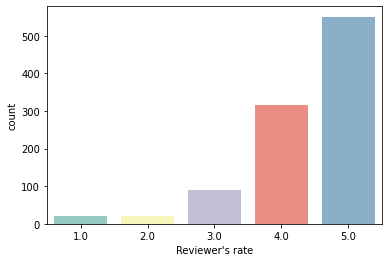

In [18]:
sns.countplot(data=data,x="Reviewer's rate", palette="Set3")

In [19]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [20]:
# Áp dụng chức năng preprocess_data cho cột đánh giá
data["Preprocessed_reviews"] = data["Reviewer's content"].apply(lambda x: preprocess_data(x))
data.head()

,Reviewer's rate,Reviewer's content,Sentiment,Word_count,Unique_word_count,Mean_word_length,Char_count,Punctuation_count,Preprocessed_reviews
0,5.0,"xây dựng quá công phunhững hoa văn, họa tiết đ...",Tốt,33,32,3.727273,155,3,xây dựng quá công phunhững hoa văn họa tiết đư...
1,4.0,Tọa lạc tại thị trấn Cát Thành - Trực Ninh – N...,Tốt,47,42,3.276596,201,4,tọa lạc tại thị trấn cát thành trực ninh nam đ...
2,4.0,We went on Tuesday morning and the doors were ...,Tốt,109,87,4.880734,642,14,went tuesday morning doors locked much great d...
3,5.0,Một trong những nhà thờ công giáo được xây dựn...,Tốt,27,27,3.444444,119,2,một trong những nhà thờ công giáo được xây dựn...
4,5.0,"khuôn viên rộng lớn, thoáng mátnơi đây thật tu...",Tốt,50,47,3.820000,240,3,khuôn viên rộng lớn thoáng mátnơi đây thật tuy...


In [25]:
def generate_ngrams(text, n_gram=1):
    """
    Returns ngrams for the given text.
    
    Parameters:
    text : for which we want ngrams
    n_gram : value for ngram
    """
    token = [token for token in text.lower().split(' ') if token != '' if token not in STOPWORDS]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [' '.join(ngram) for ngram in ngrams]

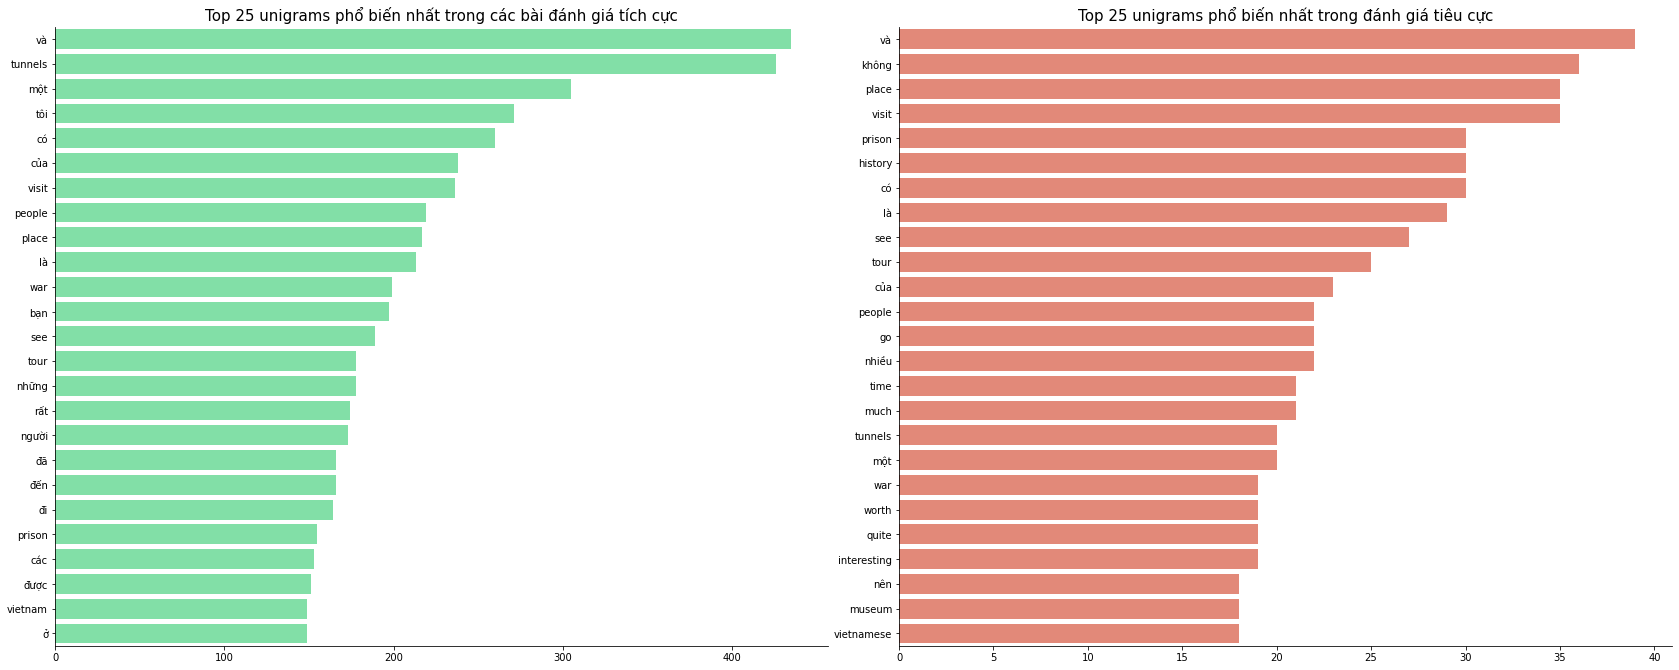

In [26]:
positive_unigrams = defaultdict(int)
negative_unigrams = defaultdict(int)
# Số ngram mình cần
N = 25
# Vòng lặp để cập nhật giá trị của positive_unigram
for review in data['Preprocessed_reviews'][data['Sentiment']=="Tốt"]:
    for word in generate_ngrams(review):
        positive_unigrams[word] += 1
for review in data['Preprocessed_reviews'][data['Sentiment']=="Tiêu cực"]:
    for word in generate_ngrams(review):
        negative_unigrams[word] += 1       
# Tạo khung dữ liệu bằng từ điển mặc định
df_positive_unigrams = pd.DataFrame(sorted(positive_unigrams.items(), key=lambda x: x[1])[::-1])
df_negative_unigrams = pd.DataFrame(sorted(negative_unigrams.items(), key=lambda x: x[1])[::-1])       
fig, axes = plt.subplots(ncols=2, figsize=(24, 10))
plt.tight_layout(pad=4.0)
# Lập biểu đồ tập dữ liệu unigram tích cực và tiêu cực
sns.despine()
sns.barplot(y = df_positive_unigrams[0].values[:N], x = df_positive_unigrams[1].values[:N], ax=axes[0], color='#72EEA4')
sns.barplot(y = df_negative_unigrams[0].values[:N], x = df_negative_unigrams[1].values[:N], ax=axes[1], color='#F37D67')
axes[0].set_title(f'Top {N} unigrams phổ biến nhất trong các bài đánh giá tích cực', fontsize=15)
axes[1].set_title(f'Top {N} unigrams phổ biến nhất trong đánh giá tiêu cực', fontsize=15)
plt.show()

# Phân tích dữ liệu thăm dò

Exploratory data analysis

Nhìn vào những ô ngram này, chúng ta có thể dễ dàng nhận ra đâu là những từ tích cực nhất và tiêu cực nhất được sử dụng trong các bài đánh giá.

Tháng 1 và tháng 10 có số lượt đánh giá cao nhất nên có thể nói rằng số lượng người ở lại khách sạn trong tháng này nhiều hơn so với các tháng khác. Tháng 4 có số lượng đánh giá thấp nhất.

Năm 2019 có số lượng đánh giá cao nhất trong khi năm 2020 có số lượng đánh giá thấp nhất vì đại dịch toàn cầu.

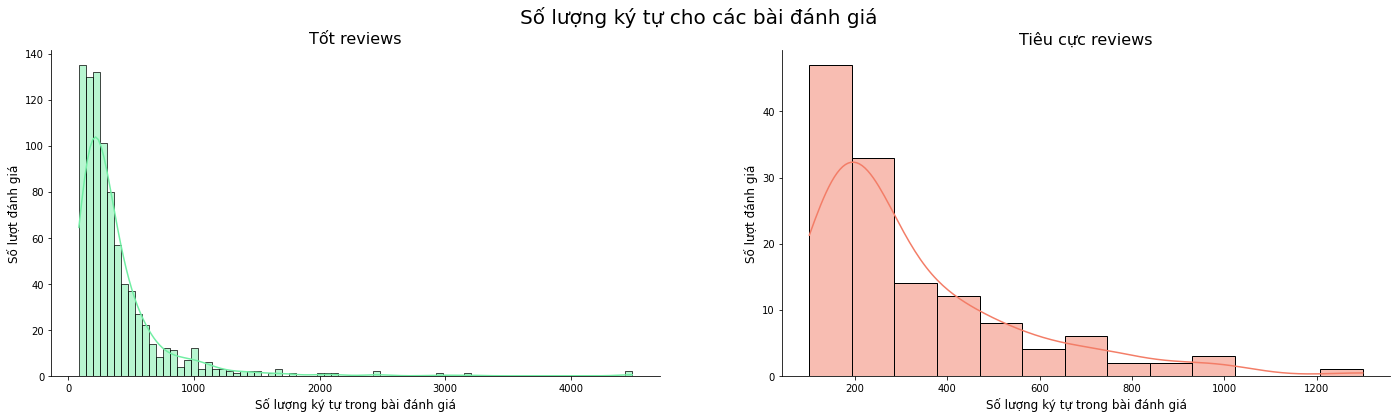

In [27]:
# Lập đồ thị số lượng ký tự cho các bài đánh giá
fig, axes = plt.subplots(ncols = 2, figsize=(24, 6))

sns.despine()
sns.histplot(ax=axes[0], x="Char_count", data=data[data['Sentiment']=='Tốt'], kde=True, color='#72EEA4');
sns.histplot(ax=axes[1], x="Char_count", data=data[data['Sentiment']=='Tiêu cực'], kde=True, color='#F37D67');

axes[0].set_title("Reviews tốt ", fontsize=16)
axes[1].set_title("Revies tiêu cực", fontsize=16)

axes[0].set_ylabel("Số lượt đánh giá", fontsize=12)
axes[1].set_ylabel("Số lượt đánh giá", fontsize=12)
axes[0].set_xlabel("Số lượng ký tự trong bài đánh giá", fontsize=12)
axes[1].set_xlabel("Số lượng ký tự trong bài đánh giá", fontsize=12)

fig.suptitle("Số lượng ký tự cho các bài đánh giá", fontsize=20)
plt.show()

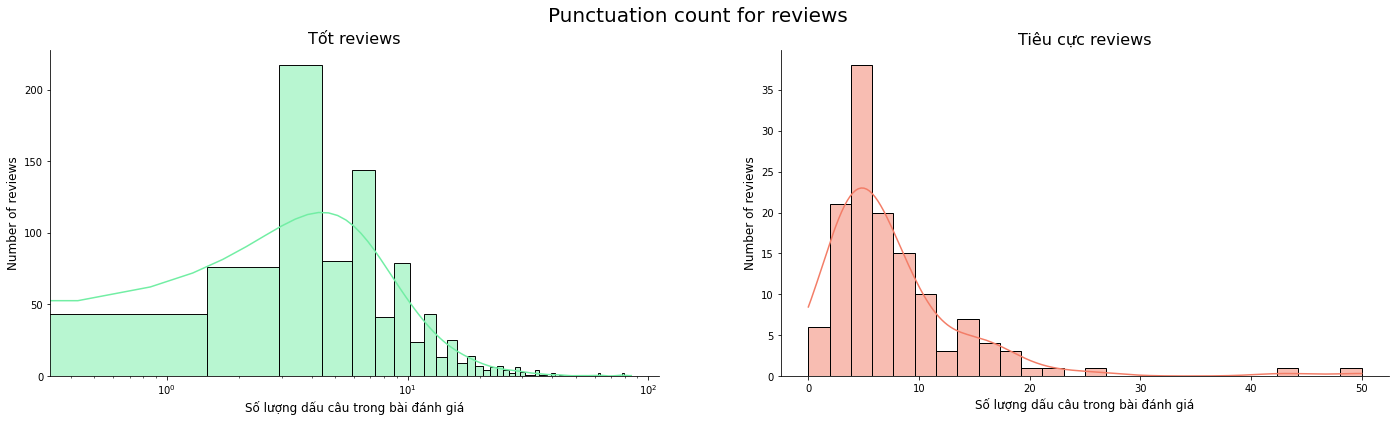

In [28]:
fig, axes = plt.subplots(ncols = 2, figsize=(24, 6))

sns.despine()
sns.histplot(ax=axes[0], x="Punctuation_count", data=data[data['Sentiment']=='Tốt'], kde=True, color='#72EEA4');
sns.histplot(ax=axes[1], x="Punctuation_count", data=data[data['Sentiment']=='Tiêu cực'], kde=True, color='#F37D67');

axes[0].set_title("Tốt reviews", fontsize=16)
axes[1].set_title("Tiêu cực reviews", fontsize=16)
axes[0].set_xscale('log')

axes[0].set_ylabel("Number of reviews", fontsize=12)
axes[1].set_ylabel("Number of reviews", fontsize=12)
axes[0].set_xlabel("Số lượng dấu câu trong bài đánh giá", fontsize=12)
axes[1].set_xlabel("Số lượng dấu câu trong bài đánh giá", fontsize=12)

fig.suptitle("Punctuation count for reviews", fontsize=20)
plt.show()

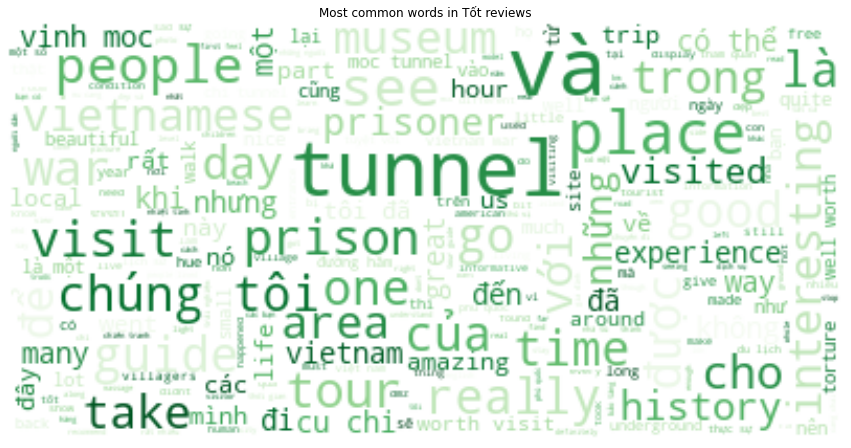

In [29]:
Tốt = " ".join(review for review in data['Preprocessed_reviews'][data['Sentiment']=="Tốt"])
wordcloud = WordCloud(background_color='white', stopwords = STOPWORDS, max_words=500, max_font_size=40, random_state=42, colormap='Greens').generate(Tốt)
plt.figure(figsize=(15, 10))
plt.title("Most common words in Tốt reviews")
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

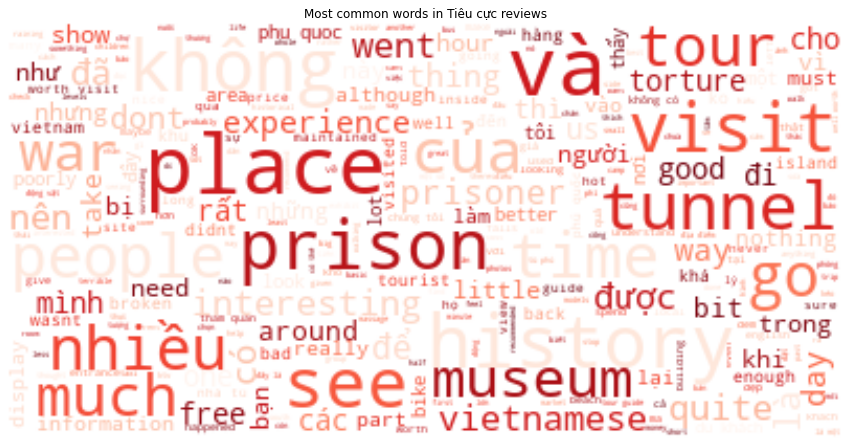

In [32]:
# Lập kế hoạch wordcloud cho các đánh giá tiêu cực
Tieucuc = " ".join(review for review in data['Preprocessed_reviews'][data['Sentiment']=="Tiêu cực"])
wordcloud = WordCloud(background_color='white', stopwords = STOPWORDS, max_words=500, max_font_size=40, random_state=42, colormap = "Reds").generate(Tieucuc)
plt.figure(figsize=(15, 10))
plt.title("Most common words in Tiêu cực reviews")
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [33]:
# Tạo các từ dừng tùy chỉnh
all_text = " ".join(list(data["Preprocessed_reviews"]))
words = pd.Series(all_text.split(" "))
frequent_words = words.value_counts()[:20]

In [34]:
# Xóa 10 từ thường gặp nhất khỏi preprocessed_reviews
data["Preprocessed_reviews"] = data["Preprocessed_reviews"].apply(lambda x: " ".join([word for word in str(x).split() if word not in frequent_words]))

In [35]:
# Sử dụng bộ mã hóa nhãn để mã hóa cột tình cảm
le = LabelEncoder()
data['Sentiment'] = le.fit_transform(data['Sentiment'])

In [37]:
# Tách tập dữ liệu thành tập dữ liệu đào tạo và kiểm tra
xtrain, xtest, ytrain, ytest = train_test_split(data["Reviewer's content"], data['Sentiment'], 
                                                  stratify=data['Sentiment'], 
                                                  random_state=42, 
                                                  test_size=0.2, shuffle=True)

In [38]:
# Tách tập dữ liệu đào tạo thành tập dữ liệu đào tạo và xác nhận
xtrain, xval, ytrain, yval = train_test_split(xtrain, ytrain, 
                                                  stratify=ytrain, 
                                                  random_state=42, 
                                                  test_size=0.1, shuffle=True)

# Mô hình training

In [39]:
# Khởi tạo TfidfVectorizer
tfv = TfidfVectorizer(min_df=3,  max_features=None, decode_error = "replace", preprocessor = preprocess_data,
            strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 3), use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = 'english')

# Lắp vectorizer Tfidf vào tập dữ liệu đào tạo
tfv.fit(list(xtrain))

# Transforming the training and validation dataset 
xtrain_tfv = tfv.transform(xtrain)
xval_tfv = tfv.transform(xval)

In [40]:
# Khởi tạo XGBClassifier
xgb = XGBClassifier(learning_rate=0.02, n_estimators=600, max_depth=4, subsample= 1.0, min_child_weight=1, gamma= 0.5, colsample_bytree= 0.8, random_state=42)

# Phù hợp xgb trên tập dữ liệu đào tạo
xgb.fit(xtrain_tfv, ytrain)

# Đưa ra dự đoán trên tập dữ liệu xác thực
predictions = xgb.predict_proba(xval_tfv)
print ("logloss: %0.3f " % log_loss(yval, predictions))

ypred_xg = xgb.predict(xval_tfv)
print(classification_report(yval, ypred_xg))

logloss: 0.452 
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.86      0.97      0.91        69

    accuracy                           0.84        80
   macro avg       0.43      0.49      0.46        80
weighted avg       0.74      0.84      0.79        80



XGBClassifier đưa ra logloss: 0.047, điểm F1 cho các đánh giá tiêu cực là 0,79 và cho các đánh giá tích cực là 1.

# Mô hình đánh giá- Model evaluation

In [42]:
# Chuyển đổi tập dữ liệu văn bản bằng cách sử dụng cùng một trình tfidfvectorizer từ tập dữ liệu đào tạo 
xtest_tfv = tfv.transform(xtest)

In [43]:
# Đưa ra dự đoán trên tập dữ liệu thử nghiệm
predictions = xgb.predict_proba(xtest_tfv)
print ("logloss: %0.3f " % log_loss(ytest, predictions))
ypred_xg = xgb.predict(xtest_tfv)
print(classification_report(ytest, ypred_xg))

logloss: 0.385 
              precision    recall  f1-score   support

           0       0.20      0.04      0.06        26
           1       0.87      0.98      0.92       174

    accuracy                           0.85       200
   macro avg       0.54      0.51      0.49       200
weighted avg       0.78      0.85      0.81       200



Đối với tập dữ liệu thử nghiệm, chúng tôi nhận được logloss: 0.044 và điểm F1 cho các đánh giá tiêu cực là 0,55 và cho các đánh giá tích cực là 0,99.